In [1]:
%%time
import bayes3d as b

CPU times: user 3.73 s, sys: 1.76 s, total: 5.49 s
Wall time: 2.83 s


In [2]:
import numpy as np
import os
import jax
import jax.numpy as jnp
import trimesh
import time
import pickle
import bayes3d.transforms_3d as t3d
import bayes3d as b
import bayes3d as j
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import namedtuple


In [3]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


# Load data

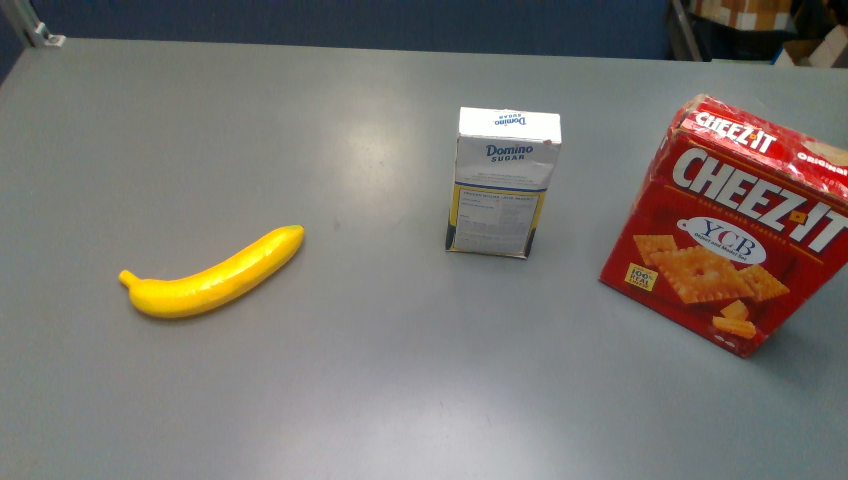

In [32]:
test_pkl_file = os.path.join(b.utils.get_assets_dir(),"sample_imgs/cracker_sugar_banana_real.pkl.rgbds")
# test_pkl_file = os.path.join(b.utils.get_assets_dir(),"sample_imgs/strawberry_error.pkl.rgbds")
# test_pkl_file = os.path.join(b.utils.get_assets_dir(),"sample_imgs/knife_spoon_box_real.pkl.rgbds")
with  open(test_pkl_file,'rb') as f:
    rgbds = pickle.load(f)
image = rgbds[0]
b.get_rgb_image(image.rgb)

# Identify table

In [36]:
original_pc_image = b.t3d.unproject_depth_jit(image.depth, image.intrinsics)
scaling_factor = 0.3
intrinsics = b.camera.scale_camera_parameters(image.intrinsics, scaling_factor)

w,h = intrinsics.width, intrinsics.height
observed_point_cloud_image = b.utils.resize(original_pc_image, intrinsics.height, intrinsics.width)
print(intrinsics)

Intrinsics(height=144, width=254, fx=182.078613282, fy=181.955969238, cx=124.554812622, cy=77.66847839399999, near=0.001, far=5.0)


In [37]:
def plane_eq_to_plane_pose(plane_eq):
    plane_eq = np.array(plane_eq)
    plane_normal = np.array(plane_eq[:3])
    point_on_plane = plane_normal * -plane_eq[3]
    plane_x = np.cross(plane_normal, np.array([1.0, 0.0, 0.0]))
    plane_y = np.cross(plane_normal, plane_x)
    R = np.vstack([plane_x, plane_y, plane_normal]).T
    plane_pose = t3d.transform_from_rot_and_pos(R, point_on_plane)
    return plane_pose

In [38]:
import pyransac3d as pyrsc
point_cloud = np.array(original_pc_image.reshape(-1,3))
point_cloud = point_cloud[point_cloud[:,2]<intrinsics.far,:]
plane1 = pyrsc.Plane()
best_eq, best_inliers = plane1.fit(point_cloud, thresh=0.0001, minPoints=100, maxIteration=1000)
plane_pose = plane_eq_to_plane_pose(best_eq)

In [39]:
import cv2
inlier_threshold=0.0001
segmentation_threshold=0.1
points_in_plane_frame = t3d.apply_transform(point_cloud, jnp.linalg.inv(plane_pose))
inliers = (jnp.abs(points_in_plane_frame[:,2]) < inlier_threshold)
inlier_plane_points = points_in_plane_frame[inliers]
inlier_table_points_seg = b.utils.segment_point_cloud(inlier_plane_points, segmentation_threshold)

most_frequent_seg_id = b.utils.get_largest_cluster_id_from_segmentation(inlier_table_points_seg)

table_points_in_plane_frame = inlier_plane_points[inlier_table_points_seg == most_frequent_seg_id]
(cx,cy), (width,height), rotation_deg = cv2.minAreaRect(np.array(table_points_in_plane_frame[:,:2]))
pose_shift = t3d.transform_from_rot_and_pos(
    t3d.rotation_from_axis_angle(jnp.array([0.0, 0.0, 1.0]), jnp.deg2rad(rotation_deg)),
    jnp.array([cx,cy, 0.0])
)
plane_pose = plane_pose.dot(pose_shift)
plane_dims = jnp.array([width, height, 1e-10])

if plane_pose[:3,2][2] > 0:
    plane_pose = plane_pose @ t3d.transform_from_axis_angle(jnp.array([1.0, 0.0, 0.0]), jnp.pi)


b.clear()
b.show_cloud("1", observed_point_cloud_image.reshape(-1,3))
b.show_pose("2", plane_pose)

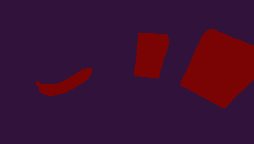

In [41]:
mask = b.segmentation.carvekit_get_foreground_mask(image)
mask = np.array(mask) * 1.0
mask = b.utils.resize(mask, intrinsics.height, intrinsics.width)

original_depth = image.depth
scaled_depth = b.utils.resize(original_depth, intrinsics.height, intrinsics.width)
scaled_depth = scaled_depth * mask
observed_point_cloud_image = b.t3d.unproject_depth(scaled_depth, intrinsics)     
b.get_depth_image(1.0*mask)

# Initialize renderer and register mesh models

In [42]:
renderer = b.Renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    renderer.add_mesh_from_file(mesh_path,scaling_factor=1.0/1000.0)
SCALING_FACTOR = 3


top_level_dir = "/home/nishadgothoskar/ptamp"
mesh_paths = [
    os.path.join(top_level_dir,"models/srl/ycb/032_knife/textured.obj"),
    os.path.join(top_level_dir,"models/srl/ycb/031_spoon/textured.obj"),
    os.path.join(top_level_dir,"models/srl/ycb/003_cracker_box/textured.obj"),
]
for p in mesh_paths:
    mesh = b.mesh.load_mesh(p)
    mesh = b.mesh.center_mesh(mesh)
    renderer.add_mesh(mesh)

# table_mesh = j.mesh.make_cuboid_mesh(3*plane_dims)
# renderer.add_mesh(table_mesh)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (256, 160, 512)


# Set coarse-to-fine schedule

In [44]:
grid_params = [
    (0.2, jnp.pi, (11,11,11)), (0.1, jnp.pi/3, (11,11,11)), (0.1, jnp.pi/5, (11,11,1)),
    (0.0, jnp.pi/2, (1,1,11*11)), (0.05, jnp.pi/5, (11,11,11)), 
    (0.03, 0.0, (16,16,1)),
    (0.0, jnp.pi/10, (1,1,11*11)),
    (0.03, 0.0, (16,16,1)),
]
contact_param_gridding_schedule = [
    b.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]
contact_poses_jit = jax.jit(jax.vmap(b.scene_graph.relative_pose_from_edge, in_axes=(0,None, None)))
contact_plane = plane_pose @ j.t3d.transform_from_pos(jnp.array([0.0, 0.0, -0.007]))


# Incremental Scene Parsing

In [53]:
# trace = Trace(
#     plane_pose[None,...], [21],
#     VARIANCE, 0.01,
#     observed_point_cloud_image
# )
VARIANCE_GRID = jnp.array([0.001])
OUTLIER_GRID = jnp.array([ 0.01])
# jnp.linspace(0.001, 0.1, 3)

trace = b.Trace(
    jnp.zeros((0,4,4)), [],
    VARIANCE_GRID[0], OUTLIER_GRID[0], 0.01,
    observed_point_cloud_image
)
b.viz_trace_meshcat(trace, renderer)

In [54]:
_all_traces = []
for _ in range(3):
    all_traces = []
    for obj_id in tqdm(range(len(renderer.meshes))):
        contact_param = jnp.zeros(3)
        p = None
        traces = None
        for c2f_iter in range(len(contact_param_gridding_schedule)):
            contact_param_grid = contact_param_gridding_schedule[c2f_iter] + contact_param

            potential_new_object_poses = contact_plane @ contact_poses_jit(
                contact_param_grid,
                3,
                renderer.model_box_dims[obj_id],
            )

            potential_poses = jnp.concatenate(
                [
                    jnp.tile(trace.poses[:,None,...], (1,potential_new_object_poses.shape[0],1,1)),
                    potential_new_object_poses[None,...]
                ]
            )

            traces = b.Traces(
                potential_poses, trace.ids + [obj_id], VARIANCE_GRID, OUTLIER_GRID,
                trace.outlier_volume, trace.observation
            )
            p = b.score_traces(traces, renderer)      

            ii,jj,kk = jnp.unravel_index(p.argmax(), p.shape)
            contact_param = contact_param_grid[ii]

        best_trace = b.Trace(
            traces.all_poses[:,ii], traces.ids, traces.all_variances[jj],
            traces.all_outlier_prob[kk], traces.outlier_volume,
            traces.observation
        )

        all_traces.append(
            best_trace
        )
        
    _all_traces.append(all_traces)

    scores = jnp.array([b.score_trace(t, renderer) for t in all_traces])
    normalized_scores = b.utils.normalize_log_scores(scores)
    print(["{:0.3f}".format(n) for n in normalized_scores])
    order = jnp.argsort(-scores)
    print(order)
    trace = all_traces[jnp.argmax(scores)]
    print(trace.ids)
    b.viz_trace_meshcat(trace, renderer)


100%|█████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.96it/s]


['0.000', '0.085', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.916']
[23  1 10 11  2 15  4  0 14 13  8  3 18  9 16 19  6  7 20 22 21  5 12 17]
[23]


100%|█████████████████████████████████████████████████████████████| 24/24 [00:08<00:00,  2.87it/s]


['0.000', '0.000', '1.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000']
[ 2 11 15  4  0 23  1 10  8  3 18  9 16 19  6 13  7 20 22 14 21  5 12 17]
[23, 2]


100%|█████████████████████████████████████████████████████████████| 24/24 [00:10<00:00,  2.29it/s]


['0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.004', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.996', '0.000', '0.000', '0.000', '0.000', '0.000']
[18  9 16 19  6  7 14 22 21  5 20 12 17 13  8  3  2  4  1 10 23  0 11 15]
[23, 2, 18]


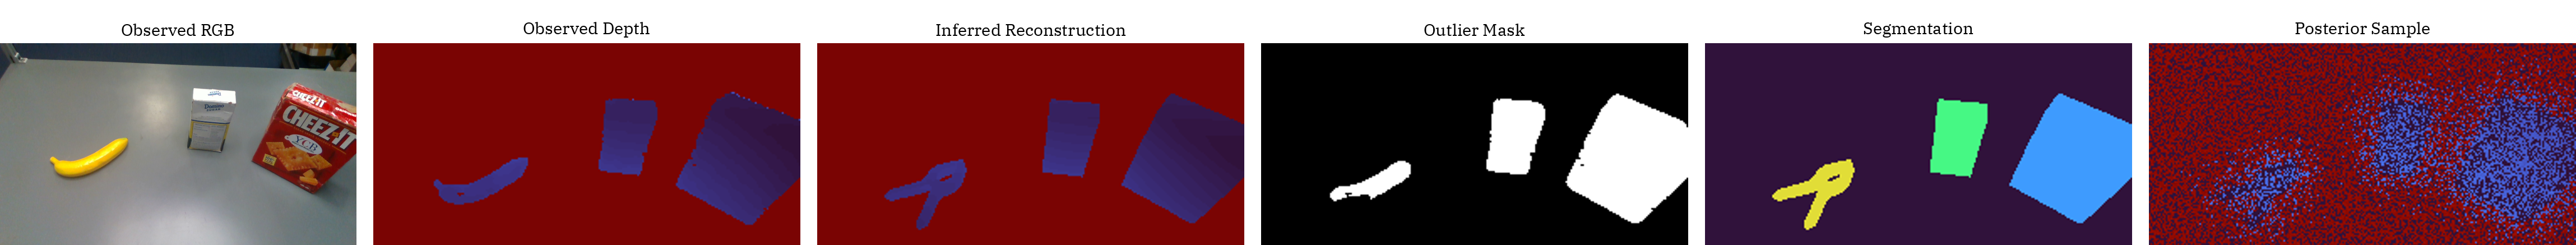

In [50]:

rgb = image.rgb
reconstruction = renderer.render_multiobject(
    trace.poses, trace.ids
)
inliers = (
    (jnp.log(1.0 - trace.outlier_prob)  + j.threedp3_likelihood_per_pixel(
        observed_point_cloud_image, reconstruction[:,:,:3], trace.variance, 0.0, 1.0, 3
    ))
        >
    jnp.log(trace.outlier_prob / trace.outlier_volume)
)

rendered_seg = reconstruction[:,:,3]
j.get_depth_image(reconstruction[:,:,2])

variance = trace.variance
key = jax.random.PRNGKey(12)

noisy_point_cloud_image = jax.random.multivariate_normal(
    key, reconstruction[:,:,:3], jnp.eye(3)*variance, shape=reconstruction.shape[:2]
)
img = j.render_point_cloud(noisy_point_cloud_image.reshape(-1,3), intrinsics)
j.scale_image(j.get_depth_image(img[:,:,2]),10)

viz2 = j.multi_panel(
    [
        j.scale_image(j.get_rgb_image(rgb),SCALING_FACTOR/4),
        j.scale_image(j.get_depth_image(observed_point_cloud_image[:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(reconstruction[:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(1.0 *inliers,cmap=plt.cm.gray, min=0.0, max=1.0), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(reconstruction[:,:,3], max=5.0), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(img[:,:,2]), SCALING_FACTOR),
    ],
    labels=[
        "Observed RGB",
        "Observed Depth",
        "Inferred Reconstruction",
        "Outlier Mask",
        "Segmentation",
        "Posterior Sample",
    ],
    middle_width=30
)

viz2